In [1]:
import sys
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F

PROJECT_ROOT = Path.cwd().parents[2]
sys.path.append(str(PROJECT_ROOT))
print("PROJECT_ROOT =", PROJECT_ROOT)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

redim_model = torch.hub.load(
    "IDRnD/ReDimNet",
    "ReDimNet",
    model_name="b5",
    train_type="ptn",
    dataset="vox2",
).to(DEVICE).eval()

print("Loaded ReDimNet successfully.")


PROJECT_ROOT = /home/SpeakerRec/BioVoice
Using device: cuda


Using cache found in /home/SpeakerRec/.cache/torch/hub/IDRnD_ReDimNet_master


Loaded ReDimNet successfully.


In [2]:
for p in redim_model.parameters():
    p.requires_grad = False

redim_model.eval()


ReDimNetWrap(
  (backbone): ReDimNet(
    (stem): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): LayerNorm(C=(32,), data_format=channels_first, eps=1e-06)
      (2): to1d()
    )
    (stage0): Sequential(
      (0): weigth1d(w=(1, 1, 1, 1),sequential=False)
      (1): to2d(f=72,c=32)
      (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (3): ConvBlock2d(
        (conv_block): ResBasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
          (conv1pw): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
          (conv2pw): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [3]:
# %% VoxCeleb2 configuration (classification)

AUDIO_ROOT = (
    PROJECT_ROOT
    / "data"
    / "datasets"
    / "voxceleb2"
    / "voxceleb2_hf"
    / "extracted_aac"
    / "aac"
)

assert AUDIO_ROOT.exists(), f"Audio root not found: {AUDIO_ROOT}"

# discover all speakers on disk
ALL_SPEAKERS = sorted([p.name for p in AUDIO_ROOT.iterdir() if p.is_dir()])
print(f"Found {len(ALL_SPEAKERS)} speakers on disk")

# take ONLY the first 50 speakers (controlled subset)
NUM_SPEAKERS = 10
MAX_SAMPLES_PER_SPEAKER = 20
SPEAKERS = ALL_SPEAKERS[:NUM_SPEAKERS]

# build class-id mappings (EXACTLY like eden/idan/yoav logic)
speaker_to_id = {s: i for i, s in enumerate(SPEAKERS)}
id_to_speaker = {i: s for s, i in speaker_to_id.items()}

print (f"Using {len(SPEAKERS)} speakers for classification task.")

def speaker_from_path(p: Path) -> str:
    """
    Given an audio file path, return speaker ID (idXXXXX).
    """
    return p.parents[1].name


# collect audio files (wav + m4a)
audio_paths = sorted(list(AUDIO_ROOT.rglob("*.wav")) + list(AUDIO_ROOT.rglob("*.m4a")))

# build dataset items (path, class_id, speaker_name)
all_items = []
for p in audio_paths:
    spk = speaker_from_path(p)

    # skip speakers not in our 50-speaker subset
    if spk not in speaker_to_id:
        continue
    
    # limit samples per speaker
    spk_count = sum(1 for _, _, s in all_items if s == spk)
    if spk_count >= MAX_SAMPLES_PER_SPEAKER:
        continue

    all_items.append((p, speaker_to_id[spk], spk))

print(f"Total audio files used: {len(all_items)}")

# optional sanity check
for s in SPEAKERS:
    count = sum(1 for _, _, sp in all_items if sp == s)
    print(s, "=", count)

Found 5558 speakers on disk
Using 10 speakers for classification task.
Total audio files used: 200
id00012 = 20
id00016 = 20
id00018 = 20
id00019 = 20
id00020 = 20
id00021 = 20
id00022 = 20
id00024 = 20
id00025 = 20
id00026 = 20


In [4]:
TARGET_SR = 16000

@torch.no_grad()
def embed_with_redim_torch(wav_path: str, l2_norm: bool = True) -> torch.Tensor:
    wav, sr = torchaudio.load(wav_path)

    if sr != TARGET_SR:
        wav = torchaudio.functional.resample(wav, sr, TARGET_SR)

    wav = wav[:1, :].float().to(DEVICE)  # [1, T]
    emb = redim_model(wav)               # [1, 192]
    emb = emb.squeeze(0)                 # [192]

    if l2_norm:
        emb = emb / (emb.norm(p=2) + 1e-12)

    return emb.detach().cpu()


In [5]:
def set_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(1234)

X = []
y = []
paths = []
speakers = []

for p, label, spk in all_items:
    emb = embed_with_redim_torch(str(p), l2_norm=True)  # [192] on CPU
    X.append(emb)
    y.append(label)
    paths.append(p)
    speakers.append(spk)

X = torch.stack(X, dim=0)          # [N, 192]
y = torch.tensor(y, dtype=torch.long)  # [N]

print("X:", X.shape, "y:", y.shape)

# optional: save to disk so you never re-embed unless you change data
# cache_path = PROJECT_ROOT / "data" / "redim_team_embeddings.pt"
# torch.save({"X": X, "y": y, "paths": paths, "speakers": speakers}, cache_path)
# print("Saved cache to:", cache_path)


X: torch.Size([200, 192]) y: torch.Size([200])


In [6]:
def split_indices_by_speaker(paths, speakers, val_ratio=0.2, seed=1234):
    rng = random.Random(seed)
    idx_by_spk = {s: [] for s in SPEAKERS}
    for i, spk in enumerate(speakers):
        idx_by_spk[spk].append(i)

    train_idx, val_idx = [], []
    for spk, idxs in idx_by_spk.items():
        rng.shuffle(idxs)
        n_val = max(1, int(len(idxs) * val_ratio))
        val_idx.extend(idxs[:n_val])
        train_idx.extend(idxs[n_val:])

    rng.shuffle(train_idx)
    rng.shuffle(val_idx)
    return train_idx, val_idx

train_idx, val_idx = split_indices_by_speaker(paths, speakers, val_ratio=0.2, seed=1234)
print("train:", len(train_idx), "val:", len(val_idx))


train: 160 val: 40


In [7]:

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val     = X[val_idx], y[val_idx]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=128, shuffle=False)


In [8]:
class SpeakerHead(nn.Module):
    def __init__(self, in_dim=192, num_classes=50):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

head = SpeakerHead(in_dim=X.shape[1], num_classes=len(SPEAKERS)).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(head.parameters(), lr=1e-3, weight_decay=1e-4)

def eval_loss_and_acc(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            logits = model(xb)
            loss = criterion(logits, yb)

            total_loss += loss.item() * yb.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.numel()

    avg_loss = total_loss / max(1, total)
    acc = correct / max(1, total)
    return avg_loss, acc


train_loss_hist = []
val_loss_hist = []
train_acc_hist = []
val_acc_hist = []

best_val = -1.0
best_state = None

EPOCHS = 60
for epoch in range(1, EPOCHS + 1):
    head.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        optimizer.zero_grad()
        logits = head(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * yb.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    val_loss, val_acc = eval_loss_and_acc(head, val_loader, criterion)
    _, train_acc = eval_loss_and_acc(head, train_loader, criterion)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    if val_acc > best_val:
        best_val = val_acc
        best_state = {k: v.detach().cpu().clone() for k, v in head.state_dict().items()}

    if epoch % 5 == 0 or epoch == 1:
        print(
            f"epoch {epoch:3d} | "
            f"train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | "
            f"train_acc {train_acc:.3f} | val_acc {val_acc:.3f} | best {best_val:.3f}"
        )

head.load_state_dict(best_state)
head.eval()
print("Best val acc:", best_val)

epoch   1 | train_loss 2.2890 | val_loss 2.2677 | train_acc 0.119 | val_acc 0.175 | best 0.175
epoch   5 | train_loss 2.1933 | val_loss 2.1803 | train_acc 0.781 | val_acc 0.750 | best 0.750
epoch  10 | train_loss 2.0772 | val_loss 2.0734 | train_acc 0.988 | val_acc 0.950 | best 0.950
epoch  15 | train_loss 1.9638 | val_loss 1.9690 | train_acc 0.988 | val_acc 0.950 | best 0.950
epoch  20 | train_loss 1.8535 | val_loss 1.8674 | train_acc 0.994 | val_acc 0.975 | best 0.975
epoch  25 | train_loss 1.7467 | val_loss 1.7691 | train_acc 0.994 | val_acc 1.000 | best 1.000
epoch  30 | train_loss 1.6438 | val_loss 1.6742 | train_acc 0.994 | val_acc 1.000 | best 1.000
epoch  35 | train_loss 1.5447 | val_loss 1.5824 | train_acc 0.994 | val_acc 1.000 | best 1.000
epoch  40 | train_loss 1.4498 | val_loss 1.4945 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  45 | train_loss 1.3594 | val_loss 1.4105 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  50 | train_loss 1.2736 | val_loss 1.3307 | 

In [9]:
head_path = PROJECT_ROOT / "data" / "heads" / "redim_speaker_head_vox2_10_20.pt"
torch.save(
    {
        "state_dict": head.state_dict(),
        "speaker_to_id": speaker_to_id,
        "speakers": SPEAKERS,
        "l2_norm_emb": True, 
    },
    head_path,
)
print("Saved head to:", head_path)


Saved head to: /home/SpeakerRec/BioVoice/data/heads/redim_speaker_head_vox2_10_20.pt


In [10]:
import pandas as pd


@torch.no_grad()
def score_wav(path: Path):
    emb = embed_with_redim_torch(str(path), l2_norm=True).to(DEVICE)  # [192]
    logits = head(emb.unsqueeze(0)).squeeze(0)  # [N_CLASSES]
    probs = F.softmax(logits, dim=0).cpu().numpy()

    pred_id = int(np.argmax(probs))
    pred_spk = id_to_speaker[pred_id]

    # sort probabilities
    sorted_idx = np.argsort(probs)[::-1]
    best_p = float(probs[sorted_idx[0]])
    second_p = float(probs[sorted_idx[1]])

    return probs, pred_spk, best_p, second_p, sorted_idx

In [11]:
rows = []

for p, true_id, true_spk in all_items:
    probs, pred_spk, best_p, second_p, sorted_idx = score_wav(p)

    p_true = float(probs[true_id])
    margin = p_true - second_p

    # top-3 predicted speakers (useful for analysis)
    top3 = [id_to_speaker[i] for i in sorted_idx[:3]]

    rows.append(
        {
            "path": str(p),
            "file": p.name,
            "true": true_spk,
            "pred": pred_spk,
            "correct": pred_spk == true_spk,
            "p_true": p_true,
            "margin": margin,
            "top1": top3[0],
            "top2": top3[1],
            "top3": top3[2],
        }
    )

df = pd.DataFrame(rows)

print("overall accuracy on all wavs:", df["correct"].mean())
TOP_N = 3
for spk in df["true"].unique():
    top = (
        df[df["true"] == spk]
        .sort_values(["margin", "p_true"], ascending=False)
        .head(TOP_N)
    )

    print("\n==== TOP", TOP_N, "for", spk, "====")
    display(top[["file", "true", "pred", "p_true", "margin", "top1", "top2", "top3"]])

overall accuracy on all wavs: 0.995

==== TOP 3 for id00012 ====


,file,true,pred,p_true,margin,top1,top2,top3
1,00002.m4a,id00012,id00012,0.183480,0.075074,id00012,id00019,id00018
0,00001.m4a,id00012,id00012,0.181880,0.074010,id00012,id00019,id00025
6,00007.m4a,id00012,id00012,0.182094,0.073505,id00012,id00019,id00021



==== TOP 3 for id00016 ====


,file,true,pred,p_true,margin,top1,top2,top3
39,00020.m4a,id00016,id00016,0.177581,0.079889,id00016,id00024,id00019
22,00003.m4a,id00016,id00016,0.178285,0.077987,id00016,id00019,id00024
34,00015.m4a,id00016,id00016,0.182243,0.071835,id00016,id00024,id00019



==== TOP 3 for id00018 ====


,file,true,pred,p_true,margin,top1,top2,top3
44,00005.m4a,id00018,id00018,0.174034,0.072025,id00018,id00021,id00012
40,00001.m4a,id00018,id00018,0.171509,0.067179,id00018,id00021,id00026
59,00020.m4a,id00018,id00018,0.173156,0.065699,id00018,id00021,id00012



==== TOP 3 for id00019 ====


,file,true,pred,p_true,margin,top1,top2,top3
79,00020.m4a,id00019,id00019,0.172871,0.075744,id00019,id00025,id00022
70,00011.m4a,id00019,id00019,0.170949,0.070916,id00019,id00021,id00012
68,00009.m4a,id00019,id00019,0.170474,0.070237,id00019,id00021,id00016



==== TOP 3 for id00020 ====


,file,true,pred,p_true,margin,top1,top2,top3
83,00004.m4a,id00020,id00020,0.177535,0.075907,id00020,id00016,id00021
95,00016.m4a,id00020,id00020,0.175983,0.072428,id00020,id00012,id00021
91,00012.m4a,id00020,id00020,0.174427,0.072245,id00020,id00012,id00018



==== TOP 3 for id00021 ====


,file,true,pred,p_true,margin,top1,top2,top3
103,00004.m4a,id00021,id00021,0.177464,0.080609,id00021,id00019,id00024
102,00003.m4a,id00021,id00021,0.176463,0.079096,id00021,id00020,id00016
119,00020.m4a,id00021,id00021,0.180092,0.077326,id00021,id00026,id00018



==== TOP 3 for id00022 ====


,file,true,pred,p_true,margin,top1,top2,top3
123,00004.m4a,id00022,id00022,0.171788,0.071784,id00022,id00021,id00025
121,00002.m4a,id00022,id00022,0.173157,0.071658,id00022,id00021,id00025
125,00006.m4a,id00022,id00022,0.172952,0.071188,id00022,id00021,id00025



==== TOP 3 for id00024 ====


,file,true,pred,p_true,margin,top1,top2,top3
152,00013.m4a,id00024,id00024,0.193659,0.090466,id00024,id00016,id00019
148,00009.m4a,id00024,id00024,0.192698,0.089333,id00024,id00016,id00019
150,00011.m4a,id00024,id00024,0.188367,0.088585,id00024,id00016,id00019



==== TOP 3 for id00025 ====


,file,true,pred,p_true,margin,top1,top2,top3
168,00009.m4a,id00025,id00025,0.187425,0.085991,id00025,id00019,id00012
161,00002.m4a,id00025,id00025,0.184112,0.084095,id00025,id00016,id00019
178,00019.m4a,id00025,id00025,0.182523,0.082303,id00025,id00016,id00012



==== TOP 3 for id00026 ====


,file,true,pred,p_true,margin,top1,top2,top3
193,00014.m4a,id00026,id00026,0.165474,0.060963,id00026,id00018,id00022
195,00016.m4a,id00026,id00026,0.168887,0.058045,id00026,id00018,id00022
198,00019.m4a,id00026,id00026,0.169749,0.057641,id00026,id00018,id00022


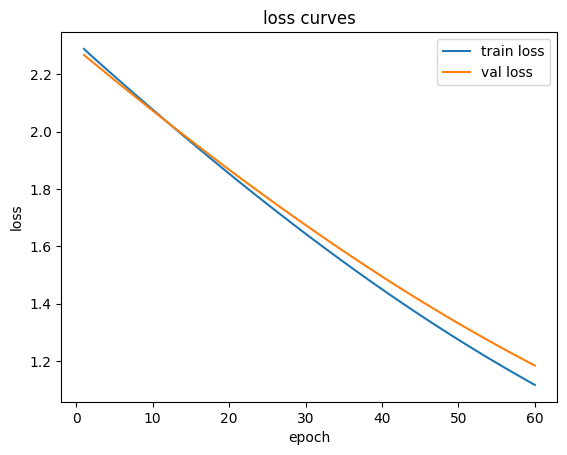

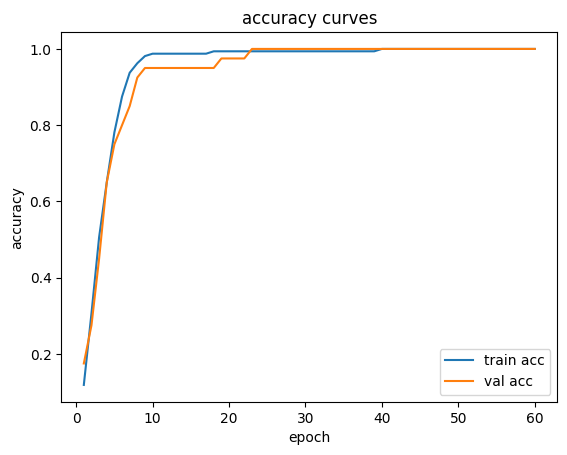

In [12]:
epochs = np.arange(1, len(train_loss_hist) + 1)

plt.figure()
plt.plot(epochs, train_loss_hist, label="train loss")
plt.plot(epochs, val_loss_hist, label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("loss curves")
plt.show()

plt.figure()
plt.plot(epochs, train_acc_hist, label="train acc")
plt.plot(epochs, val_acc_hist, label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title("accuracy curves")
plt.show()


In [13]:
cm = pd.crosstab(df["true"], df["pred"], rownames=["true"], colnames=["pred"])
display(cm)

per_class_acc = (df["true"] == df["pred"]).groupby(df["true"]).mean()
display(per_class_acc)

pred,id00012,id00016,id00018,id00019,id00020,id00021,id00022,id00024,id00025,id00026
true,,,,,,,,,,
id00012,20,0,0,0,0,0,0,0,0,0
id00016,0,20,0,0,0,0,0,0,0,0
id00018,0,0,20,0,0,0,0,0,0,0
id00019,0,0,0,20,0,0,0,0,0,0
id00020,0,0,0,0,20,0,0,0,0,0
id00021,0,0,0,0,0,20,0,0,0,0
id00022,0,0,0,0,0,0,20,0,0,0
id00024,0,0,0,0,0,0,0,20,0,0
id00025,0,0,0,0,0,0,0,0,20,0


true
id00012    1.00
id00016    1.00
id00018    1.00
id00019    1.00
id00020    1.00
id00021    1.00
id00022    1.00
id00024    1.00
id00025    1.00
id00026    0.95
dtype: float64

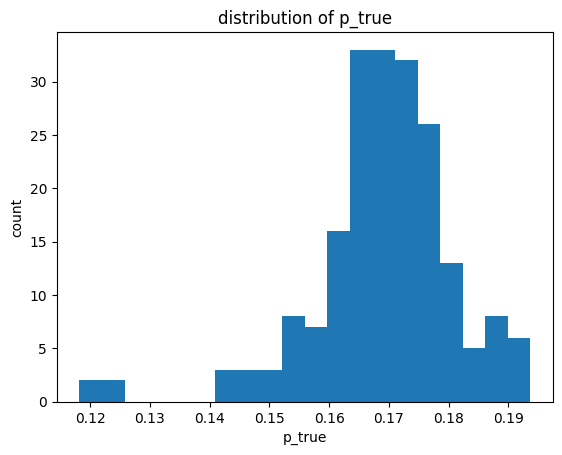

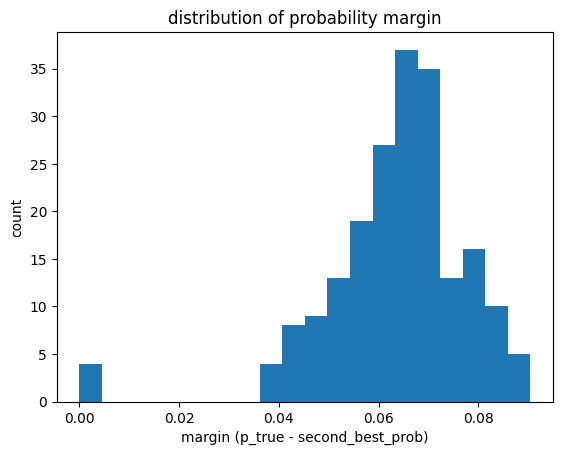

In [14]:
plt.figure()
plt.hist(df["p_true"].values, bins=20)
plt.xlabel("p_true")
plt.ylabel("count")
plt.title("distribution of p_true")
plt.show()

plt.figure()
plt.hist(df["margin"].values, bins=20)
plt.xlabel("margin (p_true - second_best_prob)")
plt.ylabel("count")
plt.title("distribution of probability margin")
plt.show()
